In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.optimize import curve_fit
from skimage.measure import block_reduce
from scipy.stats import pearsonr
import sys
import seaborn as sns
sys.path.insert(0,'/home/janssens/scripts/pp3d')
from functions import vint
from ppagg_io import load_ppagg
from dataloader import DataLoaderDALES, DataLoaderMicroHH

In [8]:
# lps = ['/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/eurec4a_mean/ppagg_new',
#        '/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/eurec4a_qtpf/ppagg',
#        '/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/eurec4a_sst_het/ppagg'
#       ]

lps = ['/scratch-shared/janssens/eurec4a_balanced_100km/ppagg_dsc',
       '/scratch-shared/janssens/eurec4a_balanced_100km_ssthetero_x/ppagg_dsc',
       '/scratch-shared/janssens/eurec4a_balanced_100km_qtpf/ppagg_dsc',]

labs = [r"Reference",
        r"$\theta_{l_s}'' = 0.2$ K",
        r"$q_{t_{sc}}'' = 1$ g/kg",
       ]

lps = ['/scratch-shared/janssens/eurec4a_balanced_25km/ppagg',
       '/scratch-shared/janssens/eurec4a_balanced_25km_dx50/ppagg',
       '/scratch-shared/janssens/eurec4a_balanced_25km_dx25_120/ppagg',
       '/scratch-shared/janssens/eurec4a_balanced_25km_dx125/ppagg',
       ]
labs = [r"25 km, dx = 100 m",
        r"25 km, dx = 50 m",
        r"25 km, dx = 25 m",
        r"25 km, dx = 12.5 m",
       ]

lps = ['/scratch-shared/janssens/eurec4a_balanced_100km/ppagg_dsc',
       '/scratch-shared/janssens/eurec4a_balanced_100km_noclouds/ppagg_dsc',
       '/scratch-shared/janssens/eurec4a_balanced_100km_qtnudged/ppagg_dsc',]
labs = [r"Reference",
        r"No clouds",
        r"Homogenised $q_{t_m}'$",
       ]


mods = ['dales','dales','dales','dales','dales']
lines = ['-','--','-.',':',(0, (1,3))]

sp = '/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/comparison'
sp = '/scratch-shared/janssens/eurec4a_comparison'
# sp = lps[-1] # Save to case you compare to baseline
# sp = '/Users/martinjanssens/Documents/Wageningen/Conferences/AGU2022'

# Loading loop
ld = []
for i in range(len(lps)):

    lp = lps[i]
    mod = mods[i]

    if mod == 'dales':
        dl = DataLoaderDALES(lp+'/..')
    elif mod == 'microhh':
        dl = DataLoaderMicroHH(lp+'/..')
    
    ld.append(load_ppagg(dl, lp))

Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions


/home/janssens/scripts/pp3d/ppagg_io.py:138: RuntimeWarning: divide by zero encountered in true_divide
  ld['Gamrat_av_time'] = ld['Gamma_qt_av_time']/ld['Gamma_thlv_av_time']


In [12]:

def plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,
                    fac=None,sharex=True,alpha=0.75,lw=2, moist_label='Moist', dry_label='Dry'):
    ndt = int((tpltmax-tpltmin)/dit)
    nvar = len(pltvars)
    if fac == None:
        fac = np.ones(len(pltvars))
    
    fig,axs = plt.subplots(nrows=ndt,ncols=nvar,figsize=(3.2*nvar,3*ndt+0.25),
                           sharex=sharex,sharey=True,squeeze=False)
    col_av = 'k'
    col_moist = plt.cm.YlOrBr(0.7)
    col_dry = plt.cm.YlOrBr(0.3)
    lns= []; lbs = []

    pltlabs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)', 't)', 'u)', 'v)', 'w)', 'x)', 'y)', 'z)']

    for l in range(len(lps)):
    
        itpltmin = np.where(ld[l]['time'][ld[l]['plttime']]>=tpltmin)[0][0]
        itpltmax = np.where(ld[l]['time'][ld[l]['plttime']]<tpltmax)[0][-1]+1
        idtplt = int(round(dit/(ld[l]['time'][ld[l]['plttime'][1]]-ld[l]['time'][ld[l]['plttime'][0]])))
        plttime_var = np.arange(itpltmin,itpltmax,idtplt)
        
        pltvars_moist = []
        pltvars_dry = []
        pltvars_av = []
        count = 0
        for p in range(nvar):
            if '_av' in pltvars[p]:
                pltvars_av.append(ld[l][pltvars[p]+'_time'])
            else:
                pltvars_moist.append(ld[l][pltvars[p]+'_moist_time'])
                pltvars_dry.append(ld[l][pltvars[p]+'_dry_time'])
        
        for i in range(len(plttime_var)):
            
            ti = ld[l]['time'][plttime_var[i]]
            itmn_min = np.where(ld[l]['time'][ld[l]['plttime']] >= ti-tav)[0][0]
            itmn_max = np.where(ld[l]['time'][ld[l]['plttime']] <= ti+tav)[0][-1]
            
            for p in range(nvar):
                if '_av' in pltvars[p]:
                    
                    pltvar_av_mn = np.mean(ld[l][pltvars[p]+'_time'][itmn_min:itmn_max,:],axis=0)*fac[p]
                    
                    diffz = len(ld[l]['zflim']) - len(pltvar_av_mn)
                    if diffz != 0:
                        zplt = ld[l]['zflim'][diffz//2:-diffz//2]
                    else:
                        zplt = ld[l]['zflim']
                    
                    lab = labs[l]+', slab-mean'
                    ln = axs[i,p].plot(pltvar_av_mn, zplt, 
                                  color=col_av, linestyle=lines[l],
                                  alpha=alpha, lw=lw)
                    if i == 0:
                        lns.append(ln[0])
                        lbs.append(lab)
                    # axs[i,p].set_xlim((-0.05,0.05))
                else:
                    pltvar_moist_mn = np.mean(ld[l][pltvars[p]+'_moist_time'][itmn_min:itmn_max,:],axis=0)*fac[p]
                    pltvar_dry_mn = np.mean(ld[l][pltvars[p]+'_dry_time'][itmn_min:itmn_max,:],axis=0)*fac[p]
                    
                    diffz = len(ld[l]['zflim']) - len(pltvar_moist_mn)
                    if diffz != 0:
                        zplt = ld[l]['zflim'][diffz//2:-diffz//2]
                    else:
                        zplt = ld[l]['zflim']
                    
                    # Ugly but works if you start with moist/dry var:
                    labm = labs[l]+', '+moist_label
                    labd = labs[l]+', '+dry_label
                    lnm = axs[i,p].plot(pltvar_moist_mn, zplt, 
                                  color=col_moist, linestyle=lines[l],
                                  alpha=alpha, lw=lw)
                    lnd = axs[i,p].plot(pltvar_dry_mn, zplt, 
                                  color=col_dry, linestyle=lines[l], 
                                  alpha=alpha, lw=lw)
                    if i == 0 and p == 0:
                        lns.append(lnm[0])
                        lns.append(lnd[0])
                        lbs.append(labm)
                        lbs.append(labd)
                
                axs[i,p].text(0.05,0.95,pltlabs[count],transform=axs[i,p].transAxes,va='top')
                count+=1
    
        for i in range(len(plttime_var)):
            axs[i,0].set_ylabel('Height [m]')
            for p in range(nvar):
                axs[i,p].set_title('%.0f'%(ld[l]['time'][plttime_var[i]]-tav)+'-'+
                                   '%.0f hr'%(ld[l]['time'][plttime_var[i]]+tav))
    
    for p in range(nvar):
        axs[-1,p].set_xlabel(varlab[p], labelpad=15)

    # axs[-1,-1].legend(loc='best',bbox_to_anchor=(1,-0.25),ncol=2)
    # fig.legend(lns, lbs, bbox_to_anchor=(0.9,-0.05),ncol=len(lps), frameon=False)
    fig.legend(lns, lbs, bbox_to_anchor=(0.9,0.05),ncol=len(lps), frameon=False)
    # fig.legend(lns, lbs, bbox_to_anchor=(0.9,-0.1),ncol=len(lps), frameon=False)
    sns.despine(offset=5)

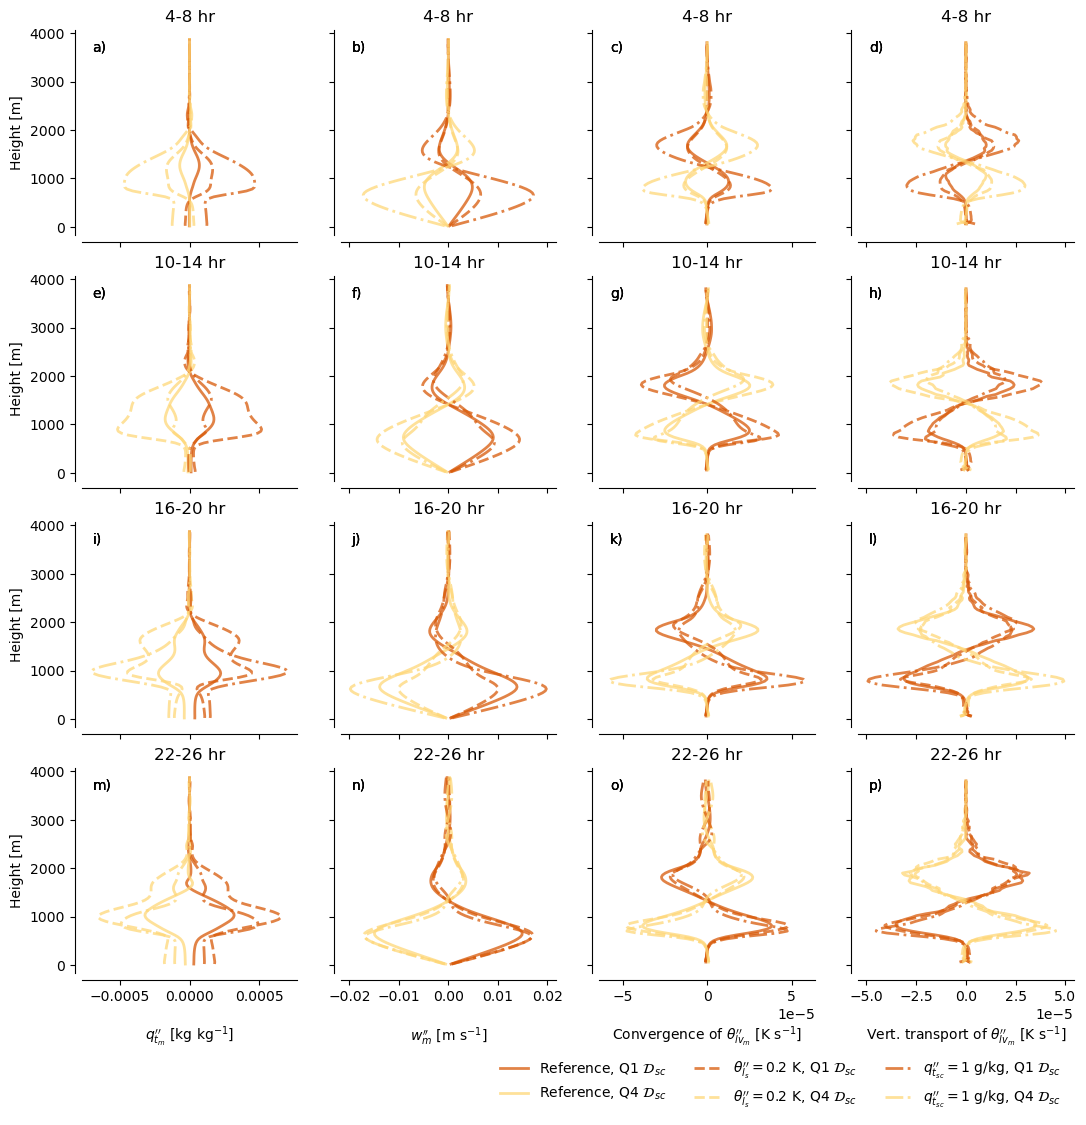

In [46]:
## FOR FORCED CASES, DO NOT USE THIS CELL OTHERWISE

# Minus 'moist_time' or 'dry_time'
pltvars = ['qtpf', 'wff','thlvpf_prod','thlvpf_vdiv']
varlab = [r"$q_{t_m}''$ [kg kg$^{-1}$]",
          r"$w_m''$ [m s$^{-1}$]",
          r"Convergence of $\theta_{lv_m}''$ [K s$^{-1}$]",
          r"Vert. transport of $\theta_{lv_m}''$ [K s$^{-1}$]",
          ]

tpltmin = 6
tpltmax = 30
dit = 6 # Rounds to closest multiple of dt in time
tav = 2.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,sharex='col', moist_label=r"Q1 $\mathcal{D}_{sc}$", dry_label=r"Q4 $\mathcal{D}_{sc}$")
plt.savefig(sp+'/comparison_vars_balanced_ssthetero_x_qtpf.pdf',bbox_inches='tight')

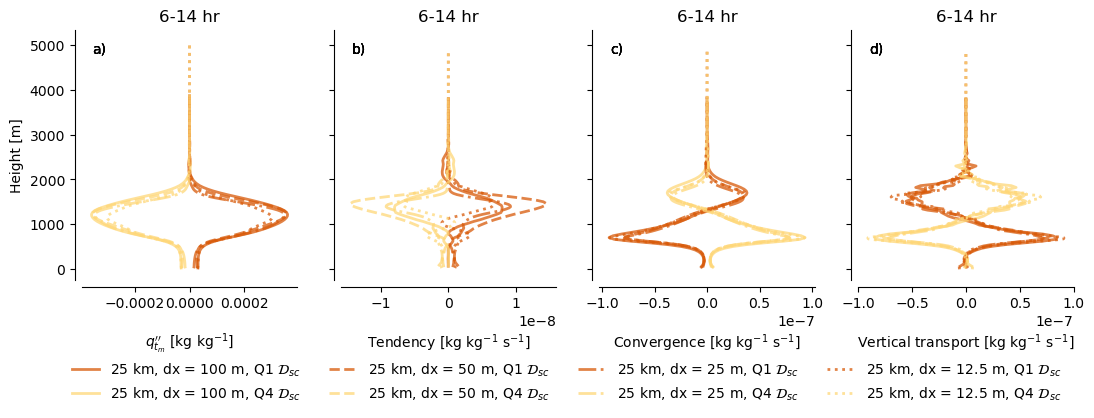

In [7]:
# FOR 25 KM CASES, DO NOT USE THIS CELL OTHERWISE

pltvars = ['qtpf','qtpf_tend','qtpf_prod_wex','qtpf_vdiv']
varlab = [r"$q_{t_m}''$ [kg kg$^{-1}$]",
          r"Tendency [kg kg$^{-1}$ s$^{-1}$]",
          r"Convergence [kg kg$^{-1}$ s$^{-1}$]", 
          r"Vertical transport [kg kg$^{-1}$ s$^{-1}$]",
          r"Horizontal transport [kg kg$^{-1}$ s$^{-1}$]",
          ]

tpltmin = 10
tpltmax = 14
dit = 4.0 # Rounds to closest multiple of dt in time
tav = 4.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines, sharex='col', moist_label=r"Q1 $\mathcal{D}_{sc}$", dry_label=r"Q4 $\mathcal{D}_{sc}$")
plt.savefig(sp+'/comparison_qtpf_resolution.pdf',bbox_inches='tight')


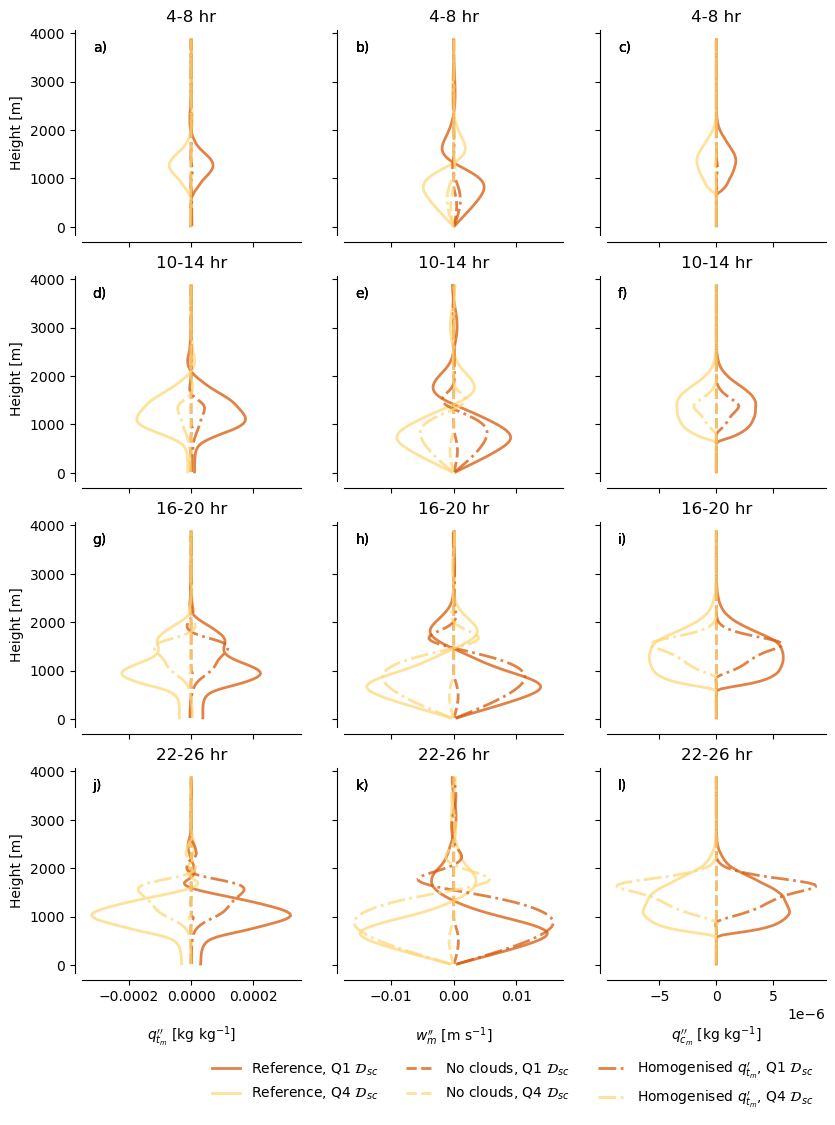

In [13]:
# Minus 'moist_time' or 'dry_time'
pltvars = ['qtpf', 'wff','qlpf']
varlab = [r"$q_{t_m}''$ [kg kg$^{-1}$]",
          r"$w_m''$ [m s$^{-1}$]",
          r"$q_{c_m}''$ [kg kg$^{-1}$]",
          ]

tpltmin = 6
tpltmax = 30
dit = 6 # Rounds to closest multiple of dt in time
tav = 2.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,sharex='col', moist_label=r"Q1 $\mathcal{D}_{sc}$", dry_label=r"Q4 $\mathcal{D}_{sc}$")
plt.savefig(sp+'/comparison_reference_noclouds_qtnudged.pdf',bbox_inches='tight')

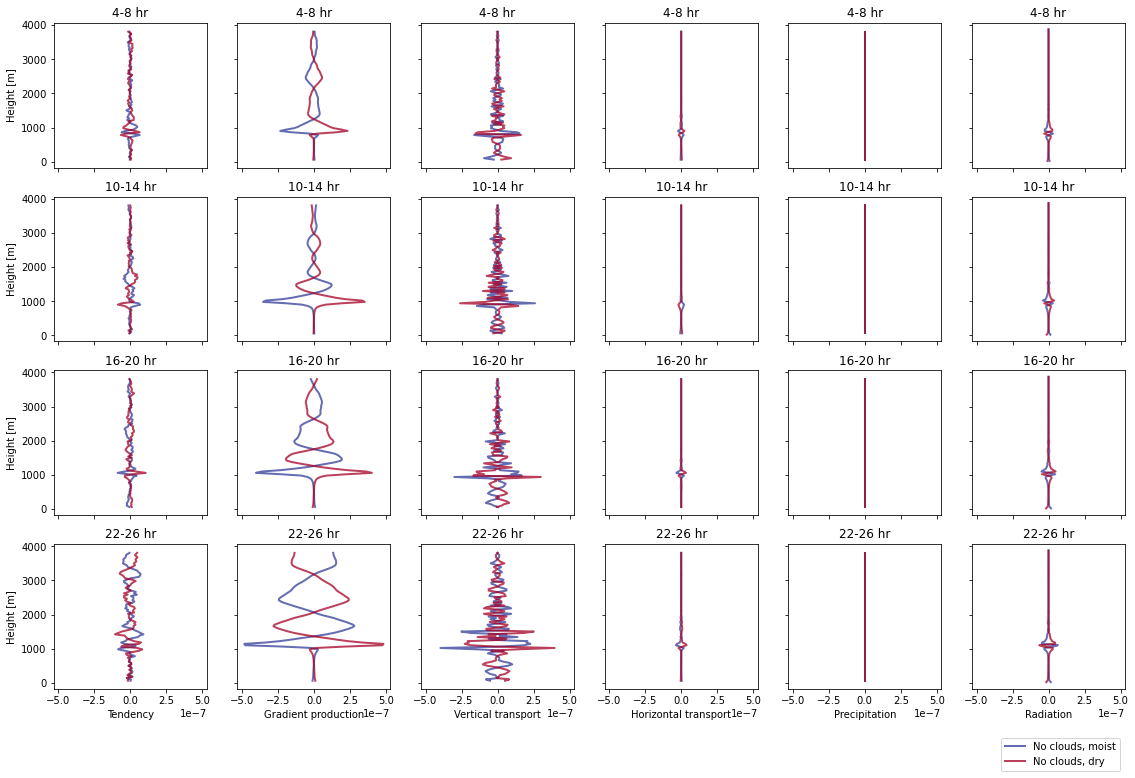

In [55]:
pltvars = ['thlvpf_tend','thlvpf_prod','thlvpf_vdiv', 'thlvpf_hdiv', 'thlvpf_micr', 'thlvpf_radi']
varlab = [r"Tendency",
          r"Gradient production", 
          r"Vertical transport",
          r"Horizontal transport",
          r"Precipitation",
          r"Radiation"]

tpltmin = 6
tpltmax = 30
dit = 6.0 # Rounds to closest multiple of dt in time
tav = 2.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines)
plt.savefig(sp+'/comparison_thlvpf.pdf',bbox_inches='tight')

This budget still always has the same structure. The WTG balance holds very well, so you can diagnose the vertical velocities in the first plot above from knowledge of the anomalous heat flux (here presented as its divergence again - termed vertical transport). Radiation and precipitation heating rates don't play a role of significance.

So this then explains the variability of the vertical velocity over time - it comes from shallowing and weakening heat fluxes. But we know that those heat fluxes are associated with the vigour of the convection, as is, by extension the energy available to transport moisture deeper into the cloud layer. Hence, something prevents the cumulus convection from remaining vigoruous and continuously building moisture fluctuations in the inversion layer. So at this point, we must ask: What is that "something" that controls the mesoscale heat flux anomaly? In our non-precipitating simulations, it was the moisture anomaly qtm. But here, precipitation must surely play a role!

Precipitation, which upon falling into the subcloud layer, evaporating and forming cold pools, will oppose the vigour of the convection in the moist patches, weaken the fluxes and lower the point where condensation turns into evaporation (or put differently, where convergence of heat fluxes - a positive latent heating anomaly - turns into divergence of heat fluxes - a negative latent heating anomaly). 

I'll have to test this, by running the case on:
 - a larger domain (say 200 km for circulations of 100 km scale)
 - cases run on for longer, for moisture statistics to approach steadiness (and hopefully better match JOANNE)
 
In the following configuration:
 - Precipiation's influence in the tendencies homogenised over the slab (i.e. eliminating cold pools)

But can we already confirm the role that precipiation has on the heat fluxes? How about correlating the precipitation anomaly with the liquid water flux anomaly, with a time-lag?

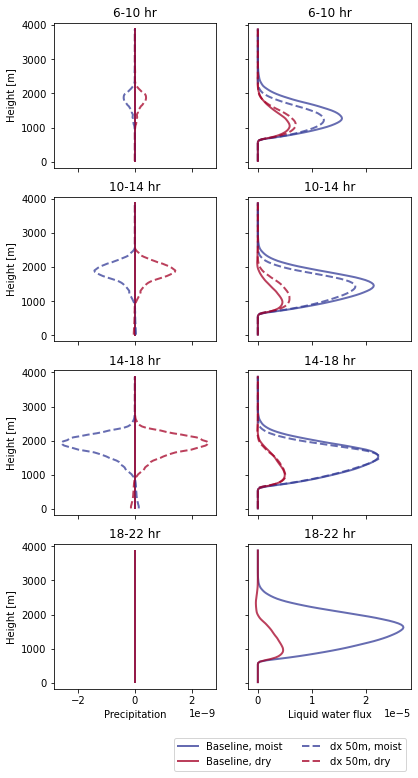

In [17]:
pltvars = ['qtpf_micr','wqlpf']
varlab = [r"Precipitation",
          r"Liquid water flux"]

tpltmin = 8
tpltmax = 24
dit = 4.0 # Rounds to closest multiple of dt in time
tav = 2.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,sharex='col')

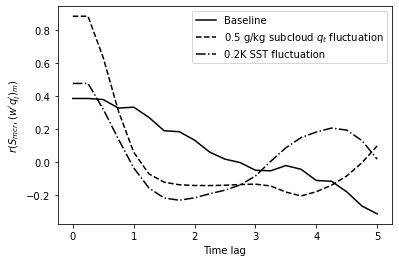

In [8]:
tlag0 = 0
tlage = 5
dtlag = 0.25

zcb = 540

tlag = np.arange(tlag0, tlage+dtlag, dtlag)

for i in range(len(lps)):
    ldi = ld[i]

    zflim = ldi['zflim']
    time = ldi['time'][ldi['plttime']]
    
    micr_moist = ldi['qtpf_micr_moist_time']
    micr_dry = ldi['qtpf_micr_dry_time']
    micr = np.concatenate((micr_moist, micr_dry))

    wqlpf_moist = ldi['wqlpf_moist_time']
    wqlpf_dry = ldi['wqlpf_dry_time']
    wqlpf = np.concatenate((wqlpf_moist, wqlpf_dry))
    
    rhobf = ldi['rhobf'][0,ldi['izmin']:ldi['izmax']]
    
    icb = np.argmin(np.abs(zflim-zcb))
    
    micri = np.trapz(rhobf[np.newaxis,:icb]*micr_moist[:,:icb],zflim[:icb],axis=1)
    wqlpfi = np.trapz(rhobf[np.newaxis,:]*wqlpf_moist,zflim,axis=1)
    
    c = np.zeros(tlag.size)
    for j in range(len(tlag)):
        itpltmin = np.where(time>=tlag[j])[0][0]
        if itpltmin != 0:
            c[j] = np.corrcoef(micri[:-itpltmin], wqlpfi[itpltmin:])[0,1]
        else:
            c[j] = np.corrcoef(micri, wqlpfi)[0,1]
    plt.plot(tlag,c,label=labs[i],c='k',linestyle=lines[i])
plt.xlabel('Time lag')
plt.ylabel(r"$r(S_{mcr},(w'q_l')_m)$")
plt.legend()

Hmm, not that convincing. There is an initial, strong correlation between the vertically integrated microphysical moisture sink (the only proxy for rain I have available here) and the liquid water flux, i.e. when the liquid water flux is strong, we also see rain, as long as the lag-times are less than 30 minutes. After this period, which does roughly correspond to a rain event, the correlation becomes positive at lag time scales of around 1 hour. But the number is small and the behaviour inconsistent between the simulations. This needs more digging!

Another question that remains is why the top lobe of the moisture fluctuation rarely is seen in the observations? There is certainly a lot of moisture variability at these levels, but not too coherent with the moistening you'd expect due to circulations, except for special situations such as flowers. Is it because of fluctuations in the Hadley cell's strength? Do gravity waves do it? All these questions remain unanswered, but what seems clear is that there's more to the picture than just shallow circulations.

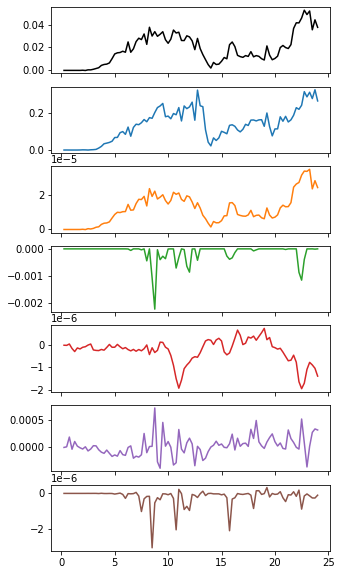

In [30]:
zcb = 540

fig,axs = plt.subplots(ncols=1,nrows=7,sharex=True,figsize=(5,10))

for i in range(1):
    ldi = ld[i]

    zflim = ldi['zflim']
    time = ldi['time'][ldi['plttime']]
    
    thlvpf_vdiv_moist = ldi['thlvpf_vdiv_moist_time']
    qtpf_moist_time = ldi['qtpf_moist_time']
    
    wthlvp_av = ldi['wthlvp_av_time']
    
    qlpf_vdiv_moist = ldi['qlpf_vdiv_moist_time']
    
    thlvpf_micr_moist = ldi['thlvpf_micr_moist_time']
    
    qtpf_hdiv_moist = ldi['qtpf_hdiv_moist_time']
    
    qtpf_micr_moist = ldi['qtpf_micr_moist_time']
    
#     div_wql_av = (wql_av[:,1:] - wql_av[:,:-1])/(zflim[np.newaxis,1:] - zflim[np.newaxis,:-1])
#     div_wql_av = (div_wql_av[:,1:] + div_wql_av[:,:-1])*0.5
    
    
#     wqlpf_moist = ldi['wqlpf_moist_time']
#     wqlpf_dry = ldi['wqlpf_dry_time']
#     wqlpf = np.concatenate((wqlpf_moist, wqlpf_dry))
    
    rhobf = ldi['rhobf'][0,ldi['izmin']:ldi['izmax']]
    
    thlvpf_conv = np.zeros(time.shape)
    twppf = np.zeros(time.shape)
    qlpf_div = np.zeros(time.shape)
    thlvpf_micrsc = np.zeros(time.shape)
    qtpf_hdivsc = np.zeros(time.shape)
    thlvpf_convsc = np.zeros(time.shape)
    qtpf_micr = np.zeros(time.shape)
    for j in range(len(time)):
        icb = np.argmin(np.abs(zflim-zcb))
        iib = np.argmin(wthlvp_av[j,:])
    
        # Anomalous, convective heating (i.e. up to max of wql_av THIS IS AN ASSUMPTION) in moist regions
        thlvpf_conv[j] = -np.trapz(rhobf[icb:iib]*thlvpf_vdiv_moist[j,icb-1:iib-1],zflim[icb:iib])
        twppf[j] = np.trapz(rhobf[icb:iib]*qtpf_moist_time[j,icb:iib],zflim[icb:iib])
        qlpf_div[j] = np.trapz(rhobf[icb:iib]*qlpf_vdiv_moist[j,icb-1:iib-1],zflim[icb:iib])
        thlvpf_micrsc[j] = np.trapz(rhobf[:icb]*thlvpf_micr_moist[j,:icb],zflim[:icb])
        qtpf_hdivsc[j] = np.trapz(rhobf[:icb]*qtpf_hdiv_moist[j,:icb],zflim[:icb])
        thlvpf_convsc[j] = -np.trapz(rhobf[1:icb]*thlvpf_vdiv_moist[j,:icb-1],zflim[1:icb])
        qtpf_micr[j] = np.trapz(rhobf[icb:iib]*qtpf_micr_moist[j,icb:iib],zflim[icb:iib])
    
#     c = np.zeros(tlag.size)
#     for j in range(len(tlag)):
#         itpltmin = np.where(time>=tlag[j])[0][0]
#         if itpltmin != 0:
#             c[j] = np.corrcoef(micri[:-itpltmin], wqlpfi[itpltmin:])[0,1]
#         else:
#             c[j] = np.corrcoef(micri, wqlpfi)[0,1]
    axs[0].plot(time,thlvpf_conv,label=labs[i],c='k',linestyle=lines[i])
    axs[1].plot(time,twppf,label=labs[i],c='C0',linestyle=lines[i])
    axs[2].plot(time,qlpf_div,label=labs[i],c='C1',linestyle=lines[i])
    axs[3].plot(time,thlvpf_micrsc,label=labs[i],c='C2',linestyle=lines[i])
    axs[4].plot(time,qtpf_hdivsc,label=labs[i],c='C3',linestyle=lines[i])
    axs[5].plot(time,thlvpf_convsc,label=labs[i],c='C4',linestyle=lines[i])
    axs[6].plot(time,qtpf_micr,label=labs[i],c='C5',linestyle=lines[i])
# plt.xlabel('Time lag')
# plt.ylabel(r"$r(S_{mcr},(w'q_l')_m)$")
# plt.legend()

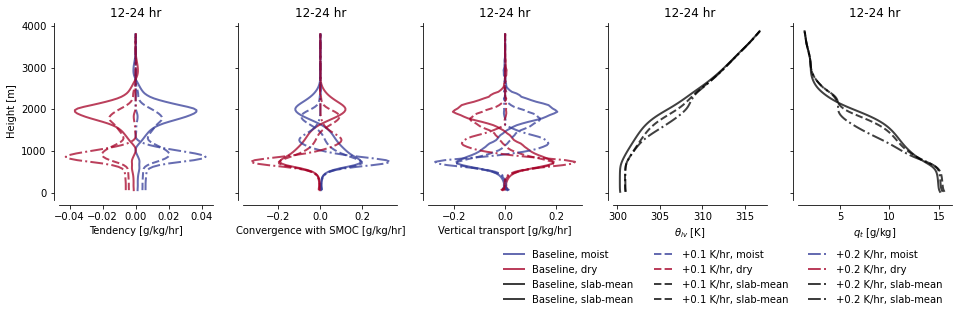

In [135]:
## Plots for AGU presentation
pltvars = ['qtpf_tend',
           'qtpf_prod_wex',
           'qtpf_vdiv',
           'thlv_av',
           'qt_av'
#            'qtpf_hdiv',
#            'qtpf_micr'
          ]
varlab = [r"Tendency [g/kg/hr]",
          r"Convergence with SMOC [g/kg/hr]", 
          r"Vertical transport [g/kg/hr]",
          r"$\theta_{lv}$ [K]",
          r"$q_t$ [g/kg]"
#           r"Horizontal transport",
#           r"Precipitation"
         ]

fqt = 1000*3600
fac = [fqt,-fqt,-fqt,1,1000]

tpltmin = 18
tpltmax = 24
dit = 6 # Rounds to closest multiple of dt in time
tav = 6 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,fac=fac,sharex='col')
plt.savefig(sp+'/comparison_qtpf_hd.pdf',bbox_inches='tight',facecolor='white')
